# San Francisco Metrosu BART projesi
Burada hangi istasyondan en fazla yolcu
taşındığını ve günün hangi saatinde yolculuk yaparsanız bir koltukta
oturarak yolculuk yapabileceğinizi hesaplayacaksınız. ve aşağıdaki
sorulara cevap vereceksiniz

Data Analytics Questions
* Which BART station is the busiest?
* What is the least popular BART route?
* When is the best time to go to SF from Berkeley if you want to find a seat?
* Which day of the week is the busiest?
* How many people take the BART late at night?

Data Science Questions
* Question A: Compute the straight line distance between every station
* Question B: Build a model that can predict the number of people commuting to work by Bart between any 2 stations:
* How would you approach that?
* What additional data would you need?
* How would you want the city or Bart officials to use your data?

Data Preparation
Append the two ridership files for 2016 and 2017
Merge the station data file
Answer data analytics questions

Dataset İnfo:
Number of passengers (Throughput) that went between two stations (Origin and Destination) in a given time (DateTime) in 2016-17
https://www.kaggle.com/datasets/saulfuh/bart-ridership

**Bay Area Rapid Transit System Map**
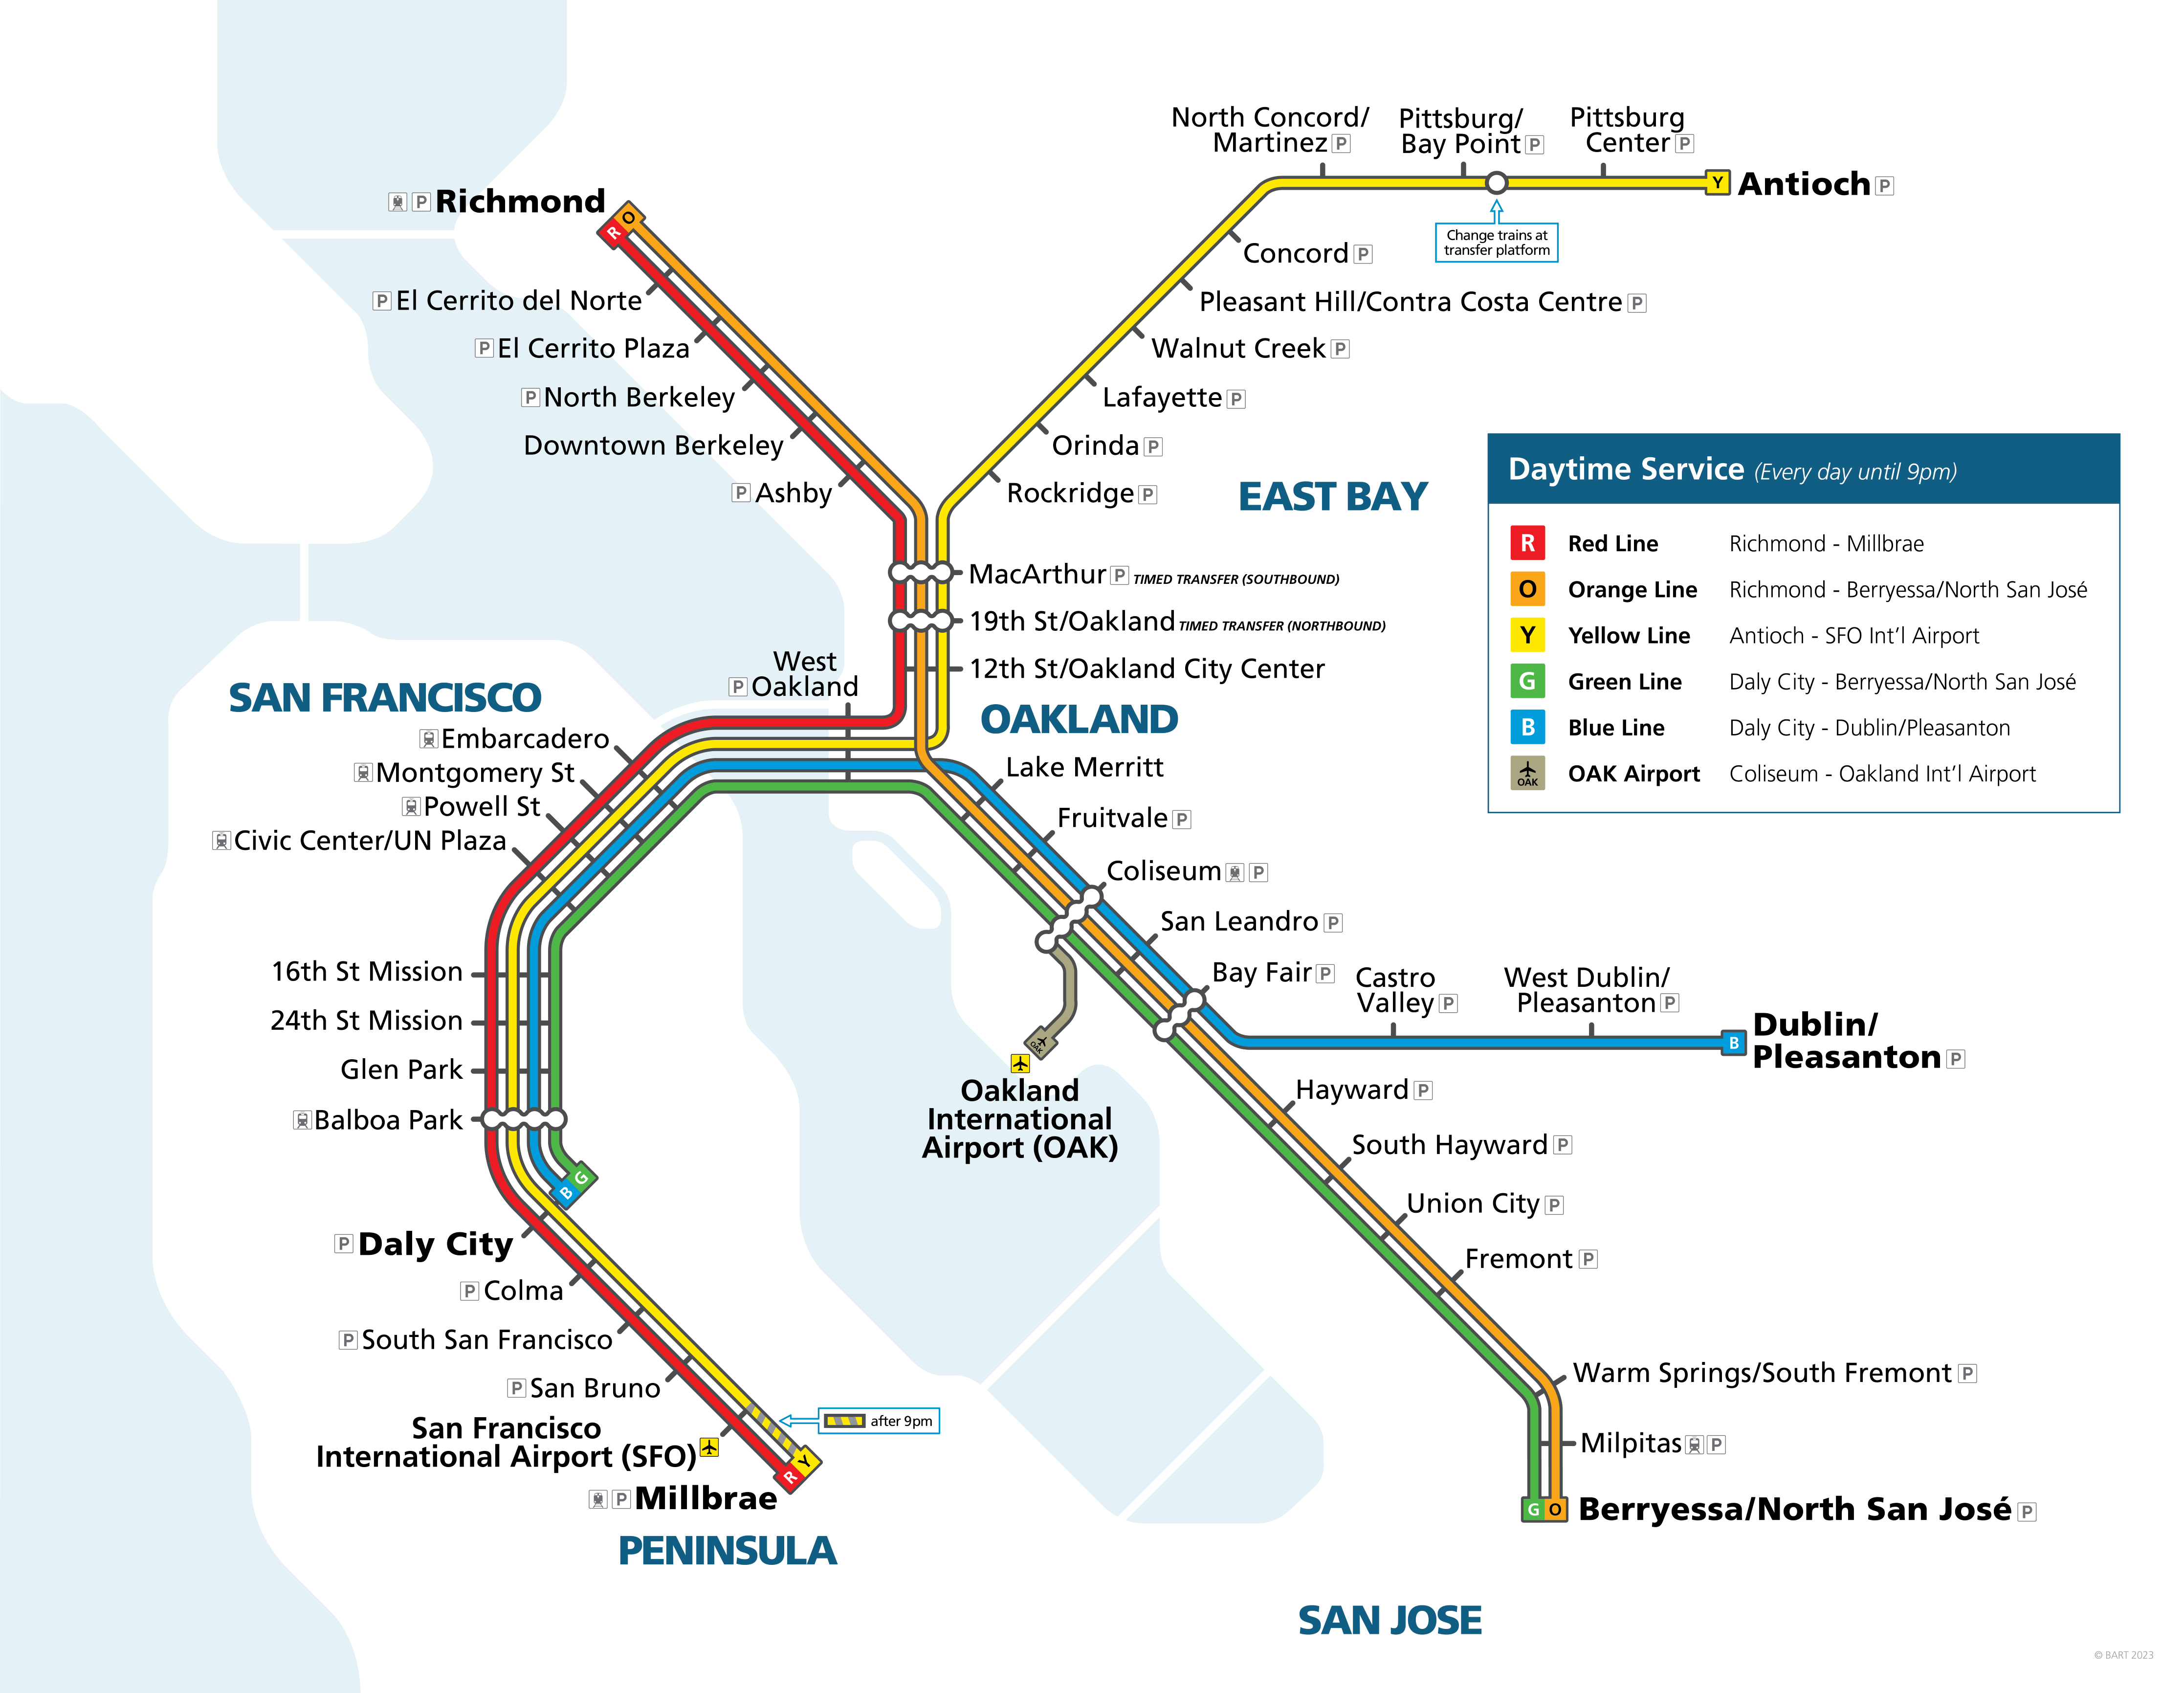

# 1. Kütüphaneler ve Veri Hazırlama

In [1]:
# Gerekli kütüphanelerin içe aktarılması
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from geopy.distance import geodesic

In [2]:
df_2016 = pd.read_csv('/kaggle/input/bart-ridership/date-hour-soo-dest-2016.csv')
df_2017 = pd.read_csv('/kaggle/input/bart-ridership/date-hour-soo-dest-2017.csv')

# İki veri setinin birleştirilmesi
df = pd.concat([df_2016, df_2017], ignore_index=True)

# İstasyon bilgilerinin yüklenmesi
stations = pd.read_csv('/kaggle/input/bart-ridership/station_info.csv')

## 1.1. EDA

In [3]:
df.tail()

,Origin,Destination,Throughput,DateTime
13285202,WSPR,MONT,1,2017-05-03 23:00:00
13285203,WSPR,NBRK,1,2017-05-03 23:00:00
13285204,WSPR,NCON,1,2017-05-03 23:00:00
13285205,WSPR,SANL,2,2017-05-03 23:00:00
13285206,WSPR,SHAY,4,2017-05-03 23:00:00


In [4]:
df.Origin.unique()

array(['12TH', '16TH', '19TH', '24TH', 'ASHB', 'BALB', 'BAYF', 'CAST',
       'CIVC', 'COLM', 'COLS', 'CONC', 'DALY', 'DBRK', 'DELN', 'DUBL',
       'EMBR', 'FRMT', 'FTVL', 'GLEN', 'HAYW', 'LAFY', 'LAKE', 'MCAR',
       'MLBR', 'MONT', 'NBRK', 'NCON', 'OAKL', 'ORIN', 'PHIL', 'PITT',
       'PLZA', 'POWL', 'RICH', 'ROCK', 'SANL', 'SBRN', 'SFIA', 'SHAY',
       'SSAN', 'UCTY', 'WCRK', 'WDUB', 'WOAK', 'WSPR'], dtype=object)

In [5]:
df.describe()

,Throughput
count,1.328521e+07
mean,1.277491e+01
std,3.351391e+01
min,1.000000e+00
25%,2.000000e+00
50%,4.000000e+00
75%,1.000000e+01
max,1.826000e+03


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13285207 entries, 0 to 13285206
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Origin       object
 1   Destination  object
 2   Throughput   int64 
 3   DateTime     object
dtypes: int64(1), object(3)
memory usage: 405.4+ MB


In [7]:
df.Destination.unique()

array(['12TH', '16TH', '24TH', 'ASHB', 'BALB', 'BAYF', 'CIVC', 'CONC',
       'DBRK', 'DELN', 'DUBL', 'EMBR', 'FTVL', 'LAFY', 'LAKE', 'MCAR',
       'MONT', 'NBRK', 'ORIN', 'PHIL', 'PITT', 'PLZA', 'POWL', 'ROCK',
       'SANL', 'SBRN', 'SHAY', 'WCRK', 'WOAK', '19TH', 'COLM', 'COLS',
       'DALY', 'GLEN', 'MLBR', 'NCON', 'RICH', 'SSAN', 'UCTY', 'WDUB',
       'CAST', 'HAYW', 'SFIA', 'FRMT', 'OAKL', 'WSPR'], dtype=object)

In [8]:
print(df.isnull().sum())
print("\n")
print(stations.isnull().sum())

Origin         0
Destination    0
Throughput     0
DateTime       0
dtype: int64


Abbreviation    0
Description     0
Location        0
Name            0
dtype: int64


# 2. Veri Analizi Soruları

## 2.1. En yoğun BART istasyonu hangisidir?

In [9]:
# Kalkış ile taşınan kişi sayısını grupladık, sum ile topladık ve idxmax ile en yüksek olanını aldık
busiest_station = df.groupby('Origin')['Throughput'].sum().idxmax() 
print(f"En yoğun BART istasyonu: {busiest_station}")

En yoğun BART istasyonu: MONT


## 2.2. En az popüler BART rotası hangisidir?

In [10]:
# Kalkış ile varış istasyonlarını grupladık, sonrasında taşınan kişi sayısını topladık en küçüğünü aldık
least_popular_route = df.groupby(['Origin', 'Destination'])['Throughput'].sum().idxmin()
print(f"En az popüler BART rotası: {least_popular_route}")

En az popüler BART rotası: ('WSPR', 'SBRN')


## 2.3. Berkeley'den SF'ye gitmek için en iyi zaman (koltuk bulmak için) nedir?

In [11]:
pd.set_option('display.max_colwidth', None)

berkeley_stations = stations[stations['Description'].str.contains("Berkeley")]
print(berkeley_stations[['Name','Description']])

                        Name  \
4               Ashby (ASHB)   
13  Downtown Berkeley (DBRK)   
26     North Berkeley (NBRK)   
32   El Cerrito Plaza (PLZA)   

                                                                                                                                                                                                                                                                                                                  Description  
4                                                                                              3100 Adeline Street, Berkeley CA 94703<br />Ashby Station is located on Ashby Avenue and Adeline Street in the southern part of Berkeley. On weekends, the City of Berkeley sponsors a popular flea market in the parking lot.  
13  2160 Shattuck Avenue, Berkeley CA 94704<br />The Downtown Berkeley BART Station is located on Shattuck Avenue between Allston Way and Addison Street. It is conveniently located close to the Unive

In [12]:
"""
4               Ashby (ASHB)   
13  Downtown Berkeley (DBRK)   
26     North Berkeley (NBRK) alınabilir.
"""

'\n4               Ashby (ASHB)   \n13  Downtown Berkeley (DBRK)   \n26     North Berkeley (NBRK) alınabilir.\n'

In [13]:
berkeley_stations = stations[stations['Description'].str.contains("San Francisco")]
print(berkeley_stations[['Name','Description']])

                                  Name  \
1              16th St. Mission (16TH)   
3              24th St. Mission (24TH)   
5                   Balboa Park (BALB)   
8         Civic Center/UN Plaza (CIVC)   
10                        Colma (COLM)   
16                  Embarcadero (EMBR)   
19                    Glen Park (GLEN)   
25               Montgomery St. (MONT)   
33                   Powell St. (POWL)   
38  San Francisco Int'l Airport (SFIA)   
40          South San Francisco (SSAN)   
45                 West Oakland (WOAK)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [14]:
"""
Name  \
1              16th St. Mission (16TH)   
3              24th St. Mission (24TH)   
5                   Balboa Park (BALB)   
8         Civic Center/UN Plaza (CIVC)     
16                  Embarcadero (EMBR)   
19                    Glen Park (GLEN)   
25               Montgomery St. (MONT)   
33                   Powell St. (POWL)   
38  San Francisco Int'l Airport (SFIA)   
40          South San Francisco (SSAN)   alınabilir.
"""

"\nName  1              16th St. Mission (16TH)   \n3              24th St. Mission (24TH)   \n5                   Balboa Park (BALB)   \n8         Civic Center/UN Plaza (CIVC)     \n16                  Embarcadero (EMBR)   \n19                    Glen Park (GLEN)   \n25               Montgomery St. (MONT)   \n33                   Powell St. (POWL)   \n38  San Francisco Int'l Airport (SFIA)   \n40          South San Francisco (SSAN)   alınabilir.\n"

In [15]:
df['DateTime'] = pd.to_datetime(df['DateTime']) # İçinden saati alabilmek için type değişimi

# Filtreleme için yeni 'Origin' ve 'Destination' kodları
origin_codes = ['DBRK', 'ASHB', 'NBRK']
destination_codes = ['EMBR', 'MONT', 'POWL', 'CIVC', 'BALB', '16TH', '24TH']

# Veri çerçevesini filtreleme
berkeley_to_sf = df[(df['Origin'].isin(origin_codes)) & (df['Destination'].isin(destination_codes))]

# Saat başına ortalama verimi hesaplayıp en düşük olanını bulma
best_time = berkeley_to_sf.groupby(berkeley_to_sf['DateTime'].dt.hour)['Throughput'].mean().idxmin()

# Sonucu yazdırma
print(f"Berkeley'den SF'ye gitmek için en iyi saat: {best_time}:00")

Berkeley'den SF'ye gitmek için en iyi saat: 4:00


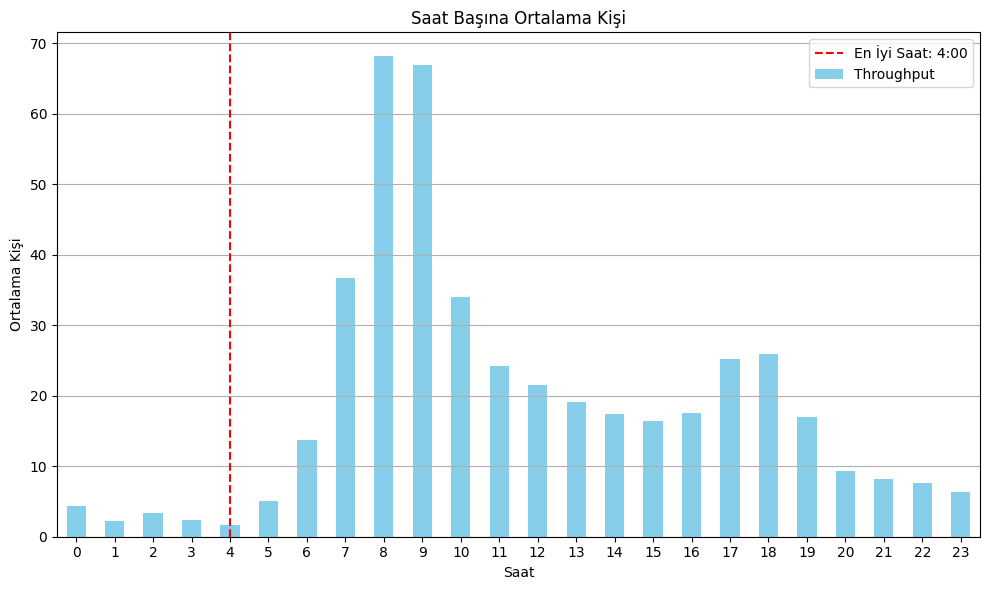

In [16]:
# Görselleştirme
hourly_throughput = berkeley_to_sf.groupby(berkeley_to_sf['DateTime'].dt.hour)['Throughput'].mean()

plt.figure(figsize=(10, 6))
hourly_throughput.plot(kind='bar', color='skyblue')
plt.title('Saat Başına Ortalama Kişi')
plt.xlabel('Saat')
plt.ylabel('Ortalama Kişi')
plt.xticks(rotation=0)
plt.grid(axis='y')
# En uygun saati vurgulama
best_time = hourly_throughput.idxmin()
plt.axvline(x=best_time, color='red', linestyle='--', label=f'En İyi Saat: {best_time}:00')
plt.legend()
plt.tight_layout()
plt.show()

## 2.4. Haftanın en yoğun günü hangisidir?

In [17]:
df['DayOfWeek'] = df['DateTime'].dt.day_name()
busiest_day = df.groupby('DayOfWeek')['Throughput'].sum().idxmax()
print(f"Haftanın en yoğun günü: {[busiest_day]}")

Haftanın en yoğun günü: ['Wednesday']


## 2.5. Gece geç saatlerde kaç kişi BART kullanıyor?

In [18]:
df['DateTime'].dt.hour.unique()

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23,  5], dtype=int32)

In [19]:
# Gece 11:00'den sabah 04:00'e kadar olan saatleri filtreleme
late_night_and_early_morning = df[
    (df['DateTime'].dt.hour >= 23) | (df['DateTime'].dt.hour < 4)
]

# İlgili Throughput toplamını hesaplama
late_night_and_early_morning_total = late_night_and_early_morning['Throughput'].sum()

print(f"Gece 11:00'den sabah 04:00'e kadar olan saatlerde BART kullanan kişi sayısı: {late_night_and_early_morning_total}")

Gece 11:00'den sabah 04:00'e kadar olan saatlerde BART kullanan kişi sayısı: 4871153


# Veri Bilimi Soruları

## A. Her istasyon arasındaki düz çizgi mesafesini hesaplayın

In [20]:
stations.tail()

,Abbreviation,Description,Location,Name
41,UCTY,"10 Union Square, Union City CA 94587<br />Incorporated in 1959, Union City combined the communities of Alvarado, Decoto, and New Haven. Alvarado was the original county seat of Alameda County, and the site of the first county courthouse is a California Historical Landmark.","-122.017388,37.590630,0",Union City (UCTY)
42,WARM,"45193 Warm Springs Blvd, Fremont, CA 94539<br />Warm Springs/South Fremont Station is currently the most southern station and is the first station to open on the new San Jose extension.","-121.939313,37.502171,0",Warm Springs/South Fremont (WARM)
43,WCRK,"200 Ygnacio Valley Road, Walnut Creek CA 94596<br />The Walnut Creek BART Station is a key piece of infrastructure for a thriving community that can also be characterized as the business and arts center for Contra Costa County.","-122.067527,37.905522,0",Walnut Creek (WCRK)
44,WDUB,"6501 Golden Gate Drive, Dublin CA 94568<br />This station straddles the border of Dublin and Pleasanton on Interstate 580 and is near the Stoneridge Shopping Center. It is BART's 44th station.","-121.928240,37.699756,0",West Dublin/Pleasanton (WDUB)
45,WOAK,"1451 7th Street, Oakland CA 94607<br />The West Oakland BART Station is located in the West Oakland residential and industrial community. The station serves both local residents and riders from throughout the region with its excellent freeway access and short ride to downtown San Francisco.","-122.295140,37.804872,0",West Oakland (WOAK)


In [21]:
from geopy.distance import geodesic  # geopy kütüphanesinden geodesic fonksiyonunu içe aktar
import pandas as pd  # pandas kütüphanesini 'pd' kısaltmasıyla içe aktar

def calculate_distances(stations):  # İstasyonlar arasındaki mesafeleri hesaplayan fonksiyon
    distances = {}  # Mesafeleri saklamak için boş bir sözlük oluştur
    for i, station1 in stations.iterrows():  # stations DataFrame'inde her satırı sırayla gez
        for j, station2 in stations.iterrows():  # Her istasyon için diğer istasyonlar arasında gez
            if i < j:  # Aynı çift için tekrar hesaplamayı önlemek için yalnızca i < j olanları al
                # Koordinatları al ve virgülle ayır, sadece enlem ve boylamı seç (0'ı göz ardı et)
                loc1 = station1['Location'].split(',')[:2]
                loc2 = station2['Location'].split(',')[:2]
                
                # Enlem ve boylamı doğru sıraya koy (geopy, enlem ve boylam sırasını bekler)
                coord1 = (float(loc1[1]), float(loc1[0]))  # Enlem ve boylamı ters çevir
                coord2 = (float(loc2[1]), float(loc2[0]))  # Enlem ve boylamı ters çevir
                
                # Mesafeyi hesapla ve mil cinsinden sonucu al
                distance = geodesic(coord1, coord2).miles
                
                # İki istasyon arasındaki mesafeyi sözlüğe ekle
                distances[(station1['Abbreviation'], station2['Abbreviation'])] = distance
    return distances  # Mesafeleri döndür

# Mesafeleri hesapla
station_distances = calculate_distances(stations)

# Mesafelerin başarıyla hesaplandığını bildir
print("İstasyonlar arası mesafeler hesaplandı.")
# Toplam hesaplanan mesafe sayısını yazdır
print(f"Toplam hesaplanan mesafe sayısı: {len(station_distances)}")

# En kısa ve en uzun mesafeleri bul
min_distance = min(station_distances.values())  # En kısa mesafeyi bul
max_distance = max(station_distances.values())  # En uzun mesafeyi bul
# Ortalama mesafeyi hesapla
avg_distance = sum(station_distances.values()) / len(station_distances)

# En kısa, en uzun ve ortalama mesafeleri yazdır
print(f"\nEn kısa mesafe: {min_distance:.2f} mil")
print(f"En uzun mesafe: {max_distance:.2f} mil")
print(f"Ortalama mesafe: {avg_distance:.2f} mil")

# İlk 5 mesafeyi göster
print("\nİlk 5 mesafe:")
for i, ((station1, station2), distance) in enumerate(list(station_distances.items())[:5], 1):
    # İlk 5 mesafeyi ve istasyon çiftlerini sırayla yazdır
    print(f"{i}. {station1} - {station2}: {distance:.2f} mil")

# En kısa ve en uzun mesafeleri içeren istasyonları bul
min_stations = [k for k, v in station_distances.items() if v == min_distance][0]  # En kısa mesafeli istasyonlar
max_stations = [k for k, v in station_distances.items() if v == max_distance][0]  # En uzun mesafeli istasyonlar

# En kısa ve en uzun mesafeleri ve ilgili istasyonları yazdır
print(f"\nEn kısa mesafe: {min_stations[0]} - {min_stations[1]}: {min_distance:.2f} mil")
print(f"En uzun mesafe: {max_stations[0]} - {max_stations[1]}: {max_distance:.2f} mil")

# Mesafe aralıklarını ve bu aralıklara düşen istasyon çiftlerinin sayısını hesapla
distance_ranges = [0, 1, 5, 10, 20, 50, 100, float('inf')]  # Mesafe aralıklarını tanımla
distance_counts = [0] * (len(distance_ranges) - 1)  # Her aralık için sayaç başlat

# Her mesafe için uygun aralığı bul ve ilgili aralıkta sayacı artır
for distance in station_distances.values():
    for i, upper_bound in enumerate(distance_ranges[1:]):
        if distance < upper_bound:
            distance_counts[i] += 1
            break

# Mesafe aralıklarındaki dağılımı yazdır
print("\nMesafe dağılımı:")
for i, count in enumerate(distance_counts):
    if i == len(distance_counts) - 1:
        # Son aralık için "X+ mil" formatında yazdır
        print(f"{distance_ranges[i]}+ mil: {count}")
    else:
        # Diğer aralıklar için "X-Y mil" formatında yazdır
        print(f"{distance_ranges[i]}-{distance_ranges[i+1]} mil: {count}")


İstasyonlar arası mesafeler hesaplandı.
Toplam hesaplanan mesafe sayısı: 1035

En kısa mesafe: 0.33 mil
En uzun mesafe: 37.65 mil
Ortalama mesafe: 15.43 mil

İlk 5 mesafe:
1. 12TH - 16TH: 8.54 mil
2. 12TH - 19TH: 0.35 mil
3. 12TH - 24TH: 8.77 mil
4. 12TH - ASHB: 3.38 mil
5. 12TH - BALB: 11.18 mil

En kısa mesafe: EMBR - MONT: 0.33 mil
En uzun mesafe: MLBR - PITT: 37.65 mil

Mesafe dağılımı:
0-1 mil: 10
1-5 mil: 107
5-10 mil: 182
10-20 mil: 431
20-50 mil: 305
50-100 mil: 0
100+ mil: 0


In [22]:
sorted(station_distances.items(), key=lambda x: x[1], reverse=True)

[(('MLBR', 'PITT'), 37.64780120345892),
 (('RICH', 'WARM'), 37.584316866025446),
 (('PITT', 'SFIA'), 37.02815265915475),
 (('PITT', 'SBRN'), 36.81366513749025),
 (('COLM', 'PITT'), 36.6539449374453),
 (('PITT', 'SSAN'), 36.64164019382474),
 (('DALY', 'PITT'), 35.86160400080521),
 (('DELN', 'WARM'), 35.7551797946963),
 (('PITT', 'WARM'), 35.63975363585714),
 (('NCON', 'WARM'), 34.86860576191987),
 (('BALB', 'PITT'), 34.27568613002942),
 (('MLBR', 'NCON'), 34.12821473819021),
 (('PLZA', 'WARM'), 33.92683222016107),
 (('NCON', 'SFIA'), 33.438545255322516),
 (('FRMT', 'RICH'), 33.31239161224785),
 (('GLEN', 'PITT'), 33.201218811728126),
 (('NCON', 'SBRN'), 33.079679609677044),
 (('CONC', 'WARM'), 32.89210807782887),
 (('NCON', 'SSAN'), 32.749282471887255),
 (('COLM', 'NCON'), 32.648872762582165),
 (('CONC', 'MLBR'), 32.35016062710838),
 (('CIVC', 'WARM'), 32.31819834473505),
 (('DALY', 'WARM'), 32.29180799203004),
 (('POWL', 'WARM'), 32.24275602446217),
 (('MONT', 'WARM'), 32.1494841206379

## B. İki istasyon arasında işe giden insan sayısını tahmin eden bir model oluşturun
### B.1 Buna nasıl yaklaşırdınız?

1. Problem
İki istasyon arasındaki işe giden insan sayısını tahmin eden bir regresyon veya dl modeli geliştirme.

2. Veri Toplama
İlgili tüm değişkenleri toplamak ve düzenlemek(İstasyonlar arası yolcu sayıları, İş merkezi konumları vb.)

3. Veri Ön İşleme ve Özellik Mühendisliği:
Eldeki datayı temizlemek ve yeni özellikler türetmek

4. Model Seçimi:
Farklı modelleri denemek

5. Model Eğitimi, performans ölçütleri, sonuçları değerlendirme ve başa dönerek iyileştirme.

### B.2. Hangi ek verilere ihtiyacınız olacak?

1. İstasyon çevresindeki nüfus yoğunluğu
2. Ekonomik göstergeler (işsizlik oranı, büyüme oranı)
3. Diğer ulaşım modları ile entegrasyon (otobüs, bisiklet paylaşımı)
4. Nufüsun toplu taşıma kullanma oranı
5. Tatil günleri ve özel etkinlikler
6. Okul dönemleri
7. Bilet fiyatları

### B.3. Şehir veya Bart yetkililerinin verilerinizi nasıl kullanmasını istersiniz?

1.Kapasite Planlaması
2.Hizmet İyileştirme
3.Fiyatlandırma Stratejileri

In [23]:
df.head()

,Origin,Destination,Throughput,DateTime,DayOfWeek
0,12TH,12TH,1,2016-01-01,Friday
1,12TH,16TH,1,2016-01-01,Friday
2,12TH,24TH,4,2016-01-01,Friday
3,12TH,ASHB,4,2016-01-01,Friday
4,12TH,BALB,2,2016-01-01,Friday


In [24]:
# yeni özellikler ekledik
df['Hour'] = df['DateTime'].dt.hour
df['Month'] = df['DateTime'].dt.month

df.to_csv("df.csv")

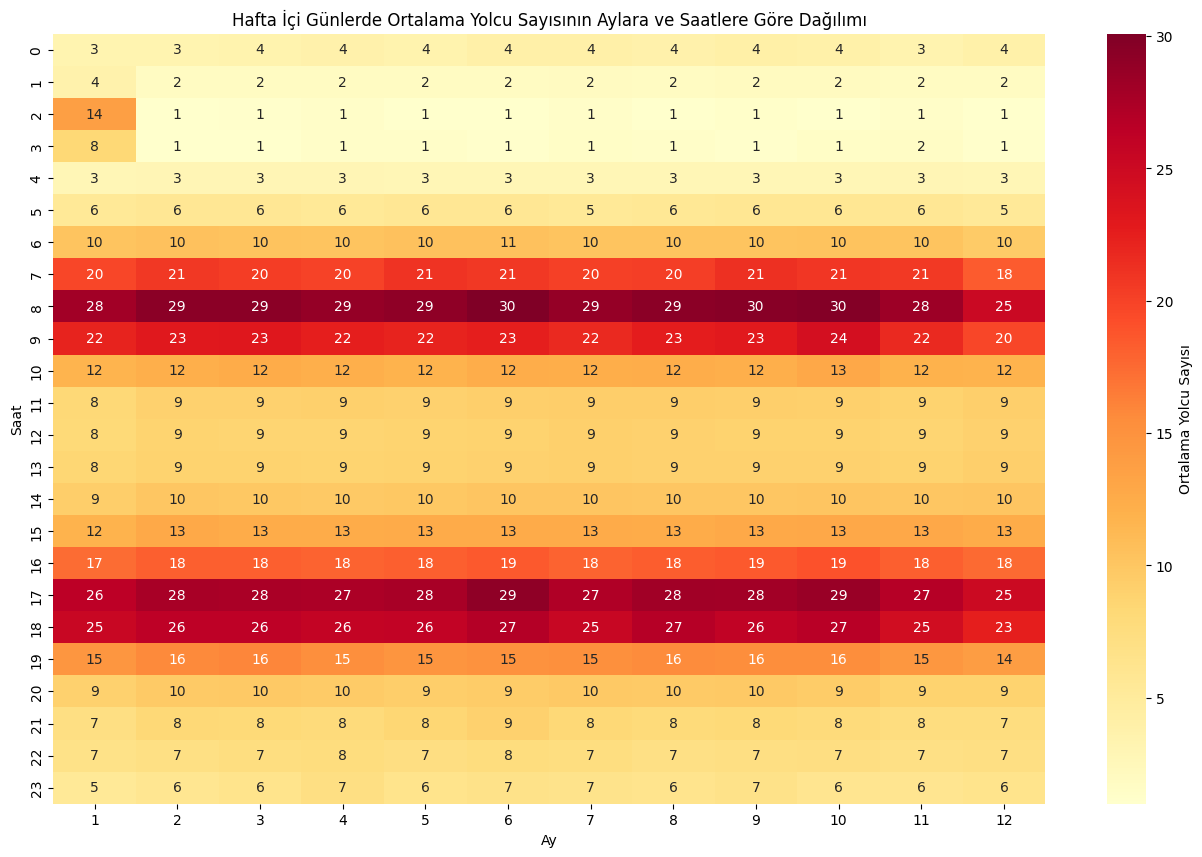

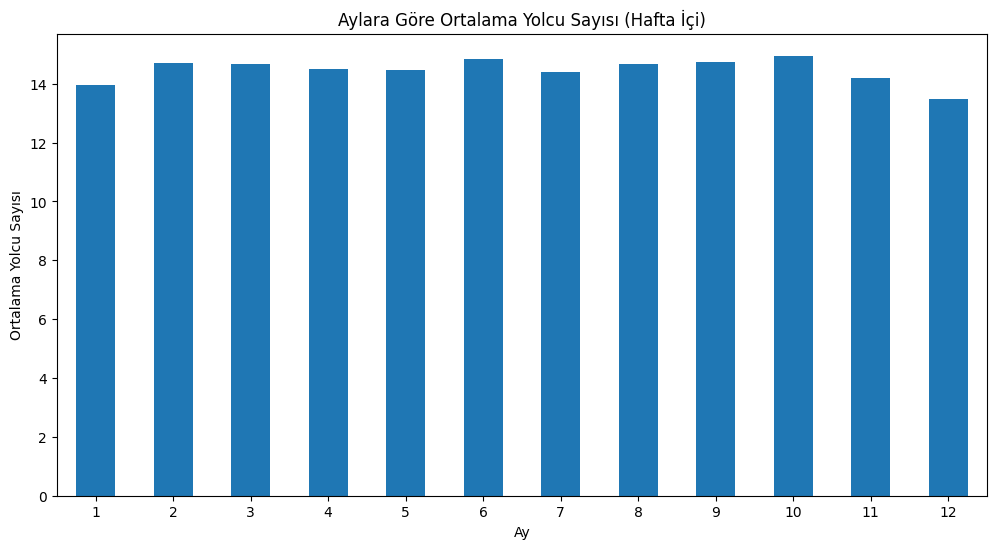

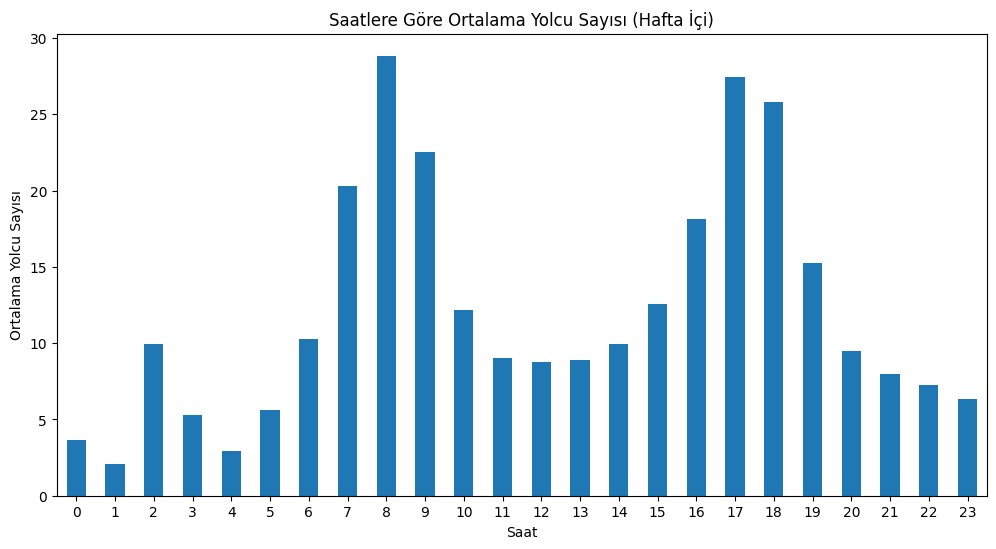

In [25]:
# DayOfWeek sütununu DateTime'dan yeniden oluşturalım
df['DayOfWeek'] = df['DateTime'].dt.dayofweek

# Hafta içi günleri filtrele (0: Pazartesi, 4: Cuma)
df_weekdays = df[df['DayOfWeek'].between(0, 4)]

# Aylara ve saatlere göre gruplama ve ortalama hesaplama
hourly_monthly_avg = df_weekdays.groupby(['Month', 'Hour'])['Throughput'].mean().reset_index()

# Pivot tablo oluştur
pivot_table = hourly_monthly_avg.pivot(index='Hour', columns='Month', values='Throughput')

# Isı haritası oluştur
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f', cbar_kws={'label': 'Ortalama Yolcu Sayısı'})
plt.title('Hafta İçi Günlerde Ortalama Yolcu Sayısının Aylara ve Saatlere Göre Dağılımı')
plt.xlabel('Ay')
plt.ylabel('Saat')
plt.show()

# Aylık toplam ortalama yolcu sayısı
monthly_avg = df_weekdays.groupby('Month')['Throughput'].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar')
plt.title('Aylara Göre Ortalama Yolcu Sayısı (Hafta İçi)')
plt.xlabel('Ay')
plt.ylabel('Ortalama Yolcu Sayısı')
plt.xticks(rotation=0)
plt.show()

# Saatlik toplam ortalama yolcu sayısı
hourly_avg = df_weekdays.groupby('Hour')['Throughput'].mean()
plt.figure(figsize=(12, 6))
hourly_avg.plot(kind='bar')
plt.title('Saatlere Göre Ortalama Yolcu Sayısı (Hafta İçi)')
plt.xlabel('Saat')
plt.ylabel('Ortalama Yolcu Sayısı')
plt.xticks(rotation=0)
plt.show()

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np


# İşe gidiş saatlerini belirle (örneğin 7-10 arası)
df['IsCommute'] = ((df['Hour'] >= 7) & (df['Hour'] <= 10)).astype(int)

# Özellik ve hedef değişkenleri ayır
X = df[['Origin', 'Destination', 'Hour', 'DayOfWeek', 'Month', 'IsCommute']]
y = df['Throughput']

# Kategorik değişkenleri one-hot encoding ile sayısallaştır
X = pd.get_dummies(X, columns=['Origin', 'Destination'])

# Veriyi eğitim ve test setlerine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest modelini oluştur ve eğit
model = RandomForestRegressor(n_estimators=20, random_state=42)
model.fit(X_train, y_train)

# Test seti üzerinde tahmin yap
y_pred = model.predict(X_test)

# Model performansını değerlendir
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Ortalama Kare Hata: {mse}")
print(f"R-kare Skoru: {r2}")

# Özellik önemliliklerini göster
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': model.feature_importances_})
print(feature_importance.sort_values('importance', ascending=False).head(10))

Ortalama Kare Hata: 115.7924383711679
R-kare Skoru: 0.8982211587934357
             feature  importance
0               Hour    0.262155
3          IsCommute    0.139654
1          DayOfWeek    0.135055
66  Destination_EMBR    0.030786
29       Origin_MONT    0.029973
20       Origin_EMBR    0.029549
75  Destination_MONT    0.026597
37       Origin_POWL    0.022935
2              Month    0.021759
9        Origin_BALB    0.018337
